In [1]:
!pip install datasets sacrebleu --quiet

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
from datasets import load_dataset
from sacrebleu import corpus_bleu

import matplotlib.pyplot as plt
import random
import time
from tqdm import tqdm
import re


C:\Users\abhis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
dataset = load_dataset("opus_books", "en-es")

raw_data = dataset["train"].shuffle(seed=42).select(range(15000))

PAD_TOKEN = "<pad>"
SOS_TOKEN = "<sos>"
EOS_TOKEN = "<eos>"
UNK_TOKEN = "<unk>"

def tokenize(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z¿¡]+", " ", text)
    return text.strip().split()

# tokenise and add <sos>, <eos> to target es only
en_sentences = [tokenize(x['translation']['en']) for x in raw_data]
es_sentences = [[SOS_TOKEN] + tokenize(x['translation']['es']) + [EOS_TOKEN] for x in raw_data]


In [3]:
from collections import Counter

def build_vocab(sentences, min_freq=2):
    counter = Counter()
    for sentence in sentences:
        counter.update(sentence)
    vocab = [PAD_TOKEN, SOS_TOKEN, EOS_TOKEN, UNK_TOKEN] + \
            [word for word, freq in counter.items() if freq >= min_freq]
    word2idx = {word: idx for idx, word in enumerate(vocab)}
    idx2word = {idx: word for word, idx in word2idx.items()}
    return vocab, word2idx, idx2word

en_vocab, en_word2idx, en_idx2word = build_vocab(en_sentences)
es_vocab, es_word2idx, es_idx2word = build_vocab(es_sentences)

print(f"English Vocab Size: {len(en_vocab)}")
print(f"Spanish Vocab Size: {len(es_vocab)}")


English Vocab Size: 11121
Spanish Vocab Size: 13268


In [ ]:
MAX_LEN_EN = 60
MAX_LEN_ES = 62  # Include <sos> and <eos>

def encode_sentence(sentence, word2idx, max_len):
    ids = [word2idx.get(tok, word2idx[UNK_TOKEN]) for tok in sentence]
    ids = ids[:max_len]
    ids += [word2idx[PAD_TOKEN]] * (max_len - len(ids))
    return ids

inputs = [encode_sentence(s, en_word2idx, MAX_LEN_EN) for s in en_sentences]
targets = [encode_sentence(s, es_word2idx, MAX_LEN_ES) for s in es_sentences]

inputs_tensor = torch.tensor(inputs, dtype=torch.long)
targets_tensor = torch.tensor(targets, dtype=torch.long)

print("Inputs shape:", inputs_tensor.shape)
print("Targets shape:", targets_tensor.shape)


Inputs shape: torch.Size([15000, 60])
Targets shape: torch.Size([15000, 62])


In [ ]:
from torch.utils.data import Dataset, DataLoader

class TranslationDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return {'src': self.inputs[idx], 'tgt': self.targets[idx]}


train_len = int(0.8 * len(inputs_tensor))
val_len = int(0.1 * len(inputs_tensor))
test_len = len(inputs_tensor) - train_len - val_len

train_set = TranslationDataset(inputs_tensor[:train_len], targets_tensor[:train_len])
val_set = TranslationDataset(inputs_tensor[train_len:train_len+val_len], targets_tensor[train_len:train_len+val_len])
test_set = TranslationDataset(inputs_tensor[-test_len:], targets_tensor[-test_len:])

BATCH_SIZE = 128
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE)


In [6]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers=1, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=en_word2idx[PAD_TOKEN])
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, (hidden, cell) = self.rnn(embedded)
        return hidden, cell  # no need to return encoder_outputs


In [7]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers=1, dropout=0.1):
        super().__init__()
        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, emb_dim, padding_idx=es_word2idx[PAD_TOKEN])
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout, batch_first=True)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, cell):
        input = input.unsqueeze(1)  # [batch_size, 1]
        embedded = self.dropout(self.embedding(input))  # [batch_size, 1, emb_dim]
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))  # [batch_size, 1, hid_dim]
        prediction = self.fc_out(output.squeeze(1))  # [batch_size, output_dim]
        return prediction, hidden, cell


In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.use_checkpoint = True

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)

        hidden, cell = self.encoder(src)
        input = trg[:, 0]  # <sos>

        for t in range(1, trg_len):
            if self.use_checkpoint:
                output, hidden, cell = checkpoint(
                    self._decoder_step, input, hidden, cell,
                    use_reentrant=False
                )
            else:
                output, hidden, cell = self.decoder(input, hidden, cell)

            outputs[:, t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[:, t] if teacher_force else top1

        return outputs

    def _decoder_step(self, input, hidden, cell):
        return self.decoder(input, hidden, cell)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

INPUT_DIM = len(en_word2idx)
OUTPUT_DIM = len(es_word2idx)

ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

encoder = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT).to(device)
decoder = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT).to(device)

model = Seq2Seq(encoder, decoder, device)
model.use_checkpoint = True

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(ignore_index=es_word2idx[PAD_TOKEN])


Using device: cuda


In [ ]:
from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler()

def train(model, dataloader, optimizer, criterion, device, epoch, total_epochs):
    model.train()
    epoch_loss = 0
    total_batches = len(dataloader)
    batch_losses = []

    progress_bar = tqdm(enumerate(dataloader), total=total_batches, desc=f"Epoch {epoch+1}/{total_epochs}")

    for i, batch in progress_bar:
        src = batch["src"].to(device)
        trg = batch["tgt"].to(device)

        optimizer.zero_grad()

        with autocast():
            output = model(src, trg)
            output_dim = output.shape[-1]
            output = output[:, 1:].reshape(-1, output_dim)
            trg = trg[:, 1:].reshape(-1)
            loss = criterion(output, trg)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()
        batch_losses.append(loss.item())

        if (i + 1) % 10 == 0:
            progress_bar.set_postfix({
                'loss': f'{epoch_loss/(i+1):.4f}',
                'lr': optimizer.param_groups[0]['lr'],
                'scale': f'{scaler.get_scale():.1f}'
            })

    return epoch_loss / total_batches, batch_losses


C:\Users\abhis\AppData\Local\Temp\ipykernel_24732\198487016.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [ ]:
from sacrebleu import corpus_bleu

def evaluate(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            src = batch["src"].to(device)
            trg = batch["tgt"].to(device)
            output = model(src, trg, teacher_forcing_ratio=0)
            preds = output.argmax(dim=-1)

            for i in range(preds.shape[0]):
                pred_tokens = [
                    es_idx2word[idx.item()]
                    for idx in preds[i]
                    if idx.item() not in [es_word2idx[PAD_TOKEN], es_word2idx[SOS_TOKEN], es_word2idx[EOS_TOKEN]]
                ]
                label_tokens = [
                    es_idx2word[idx.item()]
                    for idx in trg[i]
                    if idx.item() not in [es_word2idx[PAD_TOKEN], es_word2idx[SOS_TOKEN], es_word2idx[EOS_TOKEN]]
                ]
                all_preds.append(" ".join(pred_tokens))
                all_labels.append([" ".join(label_tokens)])

    bleu = corpus_bleu(all_preds, all_labels)
    return bleu.score


In [12]:
from torch.utils.checkpoint import checkpoint

EPOCHS = 3
all_train_batch_losses = []
epoch_train_losses = []
val_bleus = []
best_bleu = 0

for epoch in range(EPOCHS):
    start_time = time.time()

    # Train
    train_loss, batch_losses = train(model, train_loader, optimizer, criterion, device, epoch, EPOCHS)
    epoch_train_losses.append(train_loss)
    all_train_batch_losses.extend(batch_losses)

    # Evaluate
    val_bleu = evaluate(model, val_loader, device)
    val_bleus.append(val_bleu)

    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Train Loss: {train_loss:.8f}")
    print(f"  Val BLEU: {val_bleu:.8f}")
    print(f"  Time: {time.time() - start_time:.2f}s")

    if val_bleu > best_bleu:
        best_bleu = val_bleu
        torch.save(model.state_dict(), "best_seq2seq_no_attention.pt")
        print("  Best model saved!")


Epoch 1/3:   0%|          | 0/94 [00:00<?, ?it/s]C:\Users\abhis\AppData\Local\Temp\ipykernel_24732\198487016.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.56it/s]



Epoch 1 Summary:
  Train Loss: 6.80401113
  Val BLEU: 3.10790339
  Time: 121.97s
  Best model saved!


Evaluating: 100%|██████████| 12/12 [00:06<00:00,  1.72it/s]



Epoch 2 Summary:
  Train Loss: 6.47796519
  Val BLEU: 6.19245064
  Time: 123.73s
  Best model saved!


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.65it/s]



Epoch 3 Summary:
  Train Loss: 6.35997337
  Val BLEU: 10.01270693
  Time: 122.48s
  Best model saved!


In [ ]:
#on test set
model.load_state_dict(torch.load("best_seq2seq_no_attention.pt"))

test_bleu = evaluate(model, test_loader, device)

print(f"\nFinal Test BLEU Score: {test_bleu:.4f}")


C:\Users\abhis\AppData\Local\Temp\ipykernel_24732\1882959884.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_seq2seq_no_attention.


Final Test BLEU Score: 8.5566


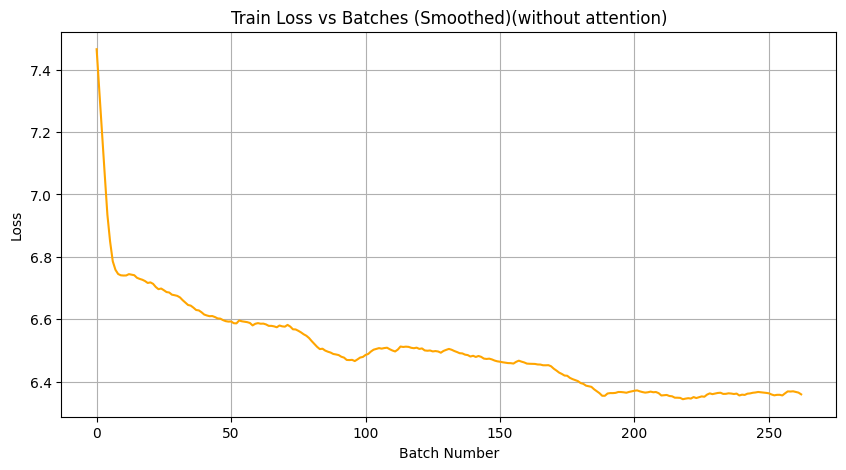

In [18]:
def moving_average(data, window_size=20):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

smoothed_losses = moving_average(all_train_batch_losses, window_size=20)

plt.figure(figsize=(10, 5))
plt.plot(smoothed_losses, color='orange')
plt.title("Train Loss vs Batches (Smoothed)(without attention)")
plt.xlabel("Batch Number")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


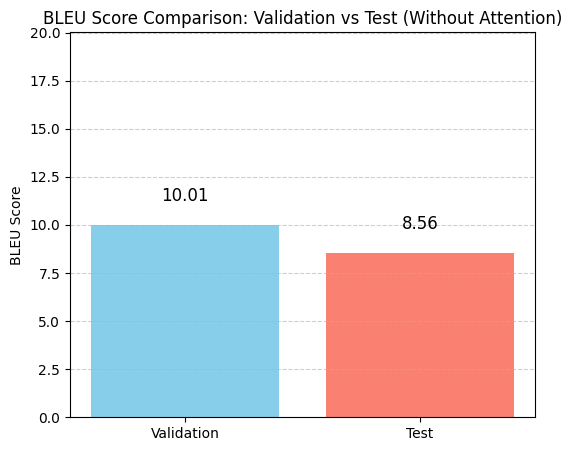

In [15]:
import matplotlib.pyplot as plt

val_bleu = 10.0127
test_bleu = 8.5566

labels = ['Validation', 'Test']
scores = [val_bleu, test_bleu]

plt.figure(figsize=(6, 5))
bars = plt.bar(labels, scores, color=['skyblue', 'salmon'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1, f'{yval:.2f}', ha='center', va='bottom', fontsize=12)

plt.title("BLEU Score Comparison: Validation vs Test (Without Attention)")
plt.ylabel("BLEU Score")
plt.ylim(0, max(scores) + 10)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


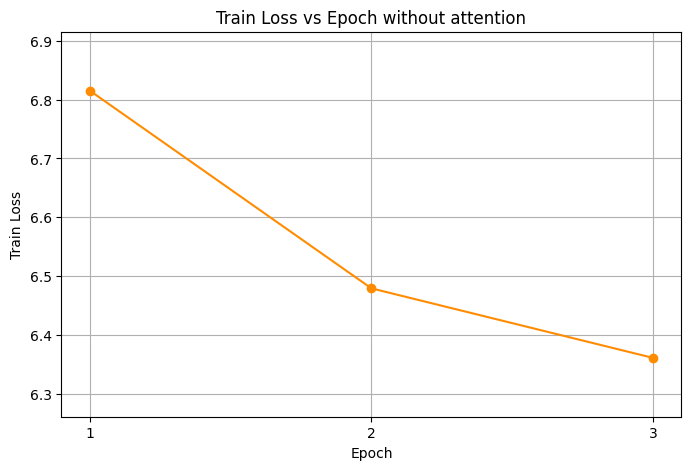

In [16]:
import matplotlib.pyplot as plt

train_losses = [6.8156, 6.4790, 6.3606]
epochs = [1, 2, 3]


plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, marker='o', linestyle='-', color='darkorange')
plt.title("Train Loss vs Epoch without attention")
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.grid(True)
plt.xticks(epochs)
plt.ylim(min(train_losses) - 0.1, max(train_losses) + 0.1)
plt.show()
